In [177]:
%%javascript

IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Homework 6: Deep Q-Networks in Pytorch

In this assignment you will implement deep q-learning using Pytorch.

In [178]:
!pip install ipywidgets

In [179]:
import copy
import math
import os
from collections import namedtuple

import gym
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import trange, tqdm
import cv2
from torchvision import transforms
from typing import Optional


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 4]

This might not work but this is ok

In [180]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: contrib dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert nbextensions_configurator notebook run
server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


#### Environment

In [181]:
def preprocess(state):
    img = transforms.functional.to_pil_image(state)

    # Apply transformations
    transform = transforms.Compose([
    transforms.CenterCrop(72),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Grayscale(num_output_channels=1)
    ])
    return transform(img)

In [182]:
class ImageEnv(gym.Wrapper):
    def __init__(
        self,
        env,
        skip_frames=4,
        stack_frames=4,
        initial_no_op=50,
        initial_op = 84,
        seed = None,
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames
        self.prev_tile_visited_count = -1
        self.missed_con = 0
        self.initial_op = initial_op
        self.seed = seed

    def reset(self):
        # Reset the original environment.
        if self.seed:
            s, info = super().reset(seed=self.seed)
        else:
            s, info = self.env.reset()

        # Do nothing for the next `self.initial_no_op` steps
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)

        # for i in range(self.initial_op):
        #     s, r, terminated, truncated, info = self.env.step(3)
        
        # for i in range(25):
        #     s, r, terminated, truncated, info = self.env.step(4)
        
        # Convert a frame to 72 X 72 gray scale one
        s = preprocess(s)

        # # The initial observation is simply a copy of the frame `s`
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))  # [4, 72, 72]
        
        return self.stacked_state, info

    def step(self, action):
        # We take an action for self.skip_frames steps
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            # if self.prev_tile_visited_count == self.tile_visited_count:
            #     r = ((int)(self.missed_con / 60) + 1) * -0.1
            #     self.missed_con += 1
            # else:
            #     self.missed_con = 0
            #     self.prev_tile_visited_count = self.tile_visited_count
            self.env.reward += r
            reward += r
            if terminated or truncated:
                break

        # Convert a frame to 72 X 72 gray scale one
        s = preprocess(s)
        # Push the current frame `s` at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s), axis=0)
        return self.stacked_state, reward, terminated, truncated, info

In [183]:
env = gym.make('CarRacing-v2', continuous=False, domain_randomize=False)
env = ImageEnv(env)

/Users/makhanizakir/opt/anaconda3/envs/ex6/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


The shape of an observation:  (4, 72, 72)


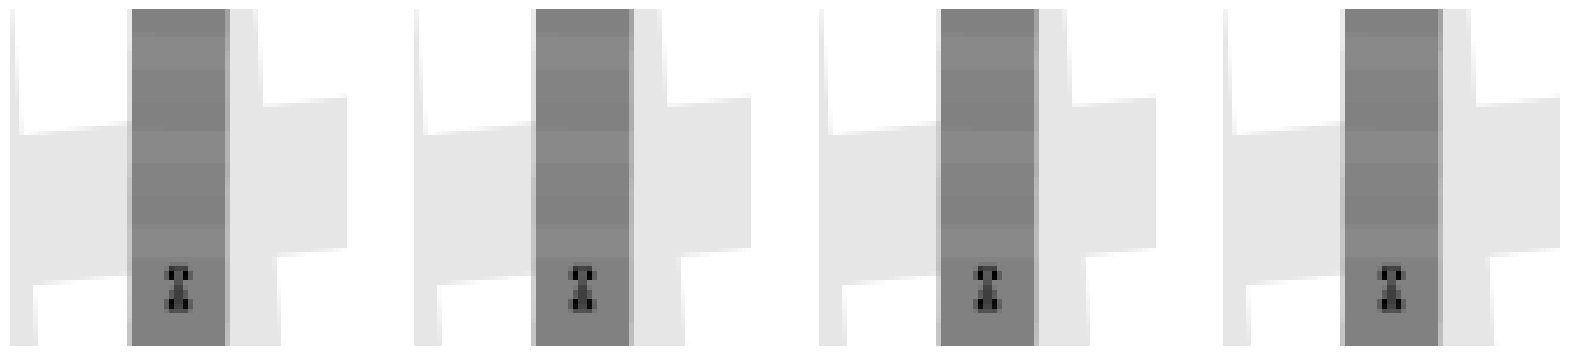

In [184]:
s, _ = env.reset()
print("The shape of an observation: ", s.shape)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

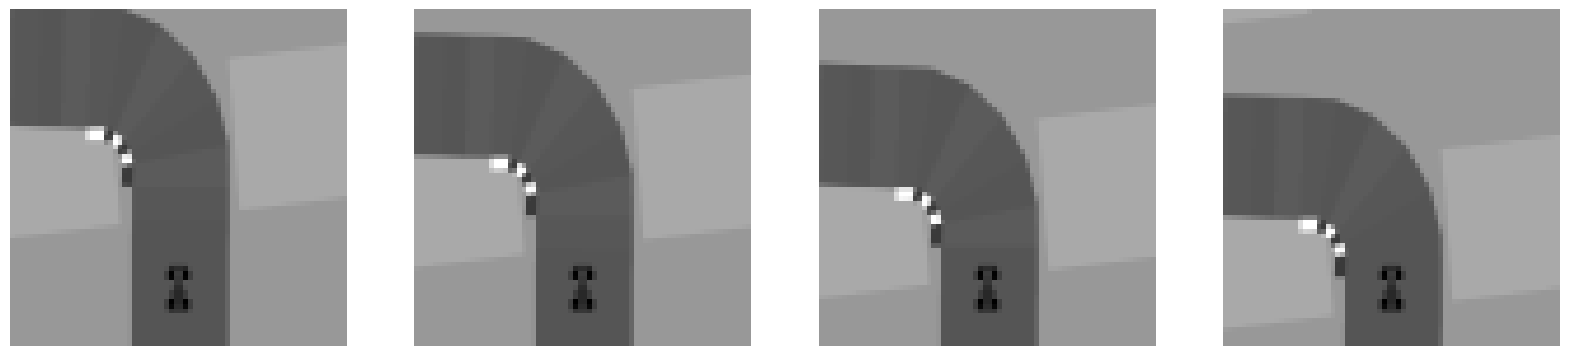

In [185]:
for i in range(25):
    s, r, terminated, truncated, info = env.step(3)  # 3rd action is `gas` action

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

In [186]:
envs = {
    'carRacing': gym.make('CarRacing-v2', continuous=False),
    'carRacingTest': gym.make('CarRacing-v2', continuous=False, domain_randomize=False)
}
image_envs = {k: ImageEnv(v) for k, v in envs.items()}
image_envs['carRacingTest'].seed = 42
image_envs['carRacing'].seed = None

These environments are particularly cool because they all include a graphical visualization which we can use to visualize our learned policies.  Run the following cell and click the buttons to run the visualization with a random policy.

In [187]:
def render(env_param, policy=None):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action.  If None, the random
                    policy is used.
    """
    if (env_param == ImageEnv(envs['carRacing'])):
        env = ImageEnv(gym.make('CarRacing-v2', continuous=False, render_mode="human"))
    else:
        env = ImageEnv(gym.make('CarRacing-v2', continuous=False ,render_mode="human", domain_randomize=False))

    if policy is None:

        def policy(state):
            return env.action_space.sample()

    state = env.reset()[0]
    env.render()

    while True:
        action = policy(state)
        res = env.step(action)
        state = res[0]
        done = res[2]
        # state, _, done, _ = env.step(action)
        env.render()

        if done:
            break
            
    env.close()

In [188]:
#  Jupyter UI

def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = envs[button.description]
    render(env)
    env.close()

    for b in buttons:
        b.disabled = False

buttons = []
for env_id in envs.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print('Click a button to run a random policy:')
widgets.HBox(buttons)

Click a button to run a random policy:


## Misc Utilities

### Smoothing

In [189]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

### Exponential $\epsilon$-Greedy Decay

This time we'll switch from using a linear decay to an exponential decay, defined as
$$\epsilon_t = a \exp (b t)$$
where $a$ and $b$ are the parameters of the schedule.

In [190]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: initial value
        :param value_to: final value
        :param num_steps: number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        #  determine the `a` and `b` parameters such that the schedule is correct
        self.b = math.log(value_to / value_from) / (num_steps - 1)
        self.a = value_from

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step:  The step at which to compute the interpolation.
        :rtype: float.  The interpolated value.
        """

        # implement the schedule rule as described in the docstring,
        # using attributes `self.a` and `self.b`.
        if step <= 0:
            value = self.value_from
        elif step >= self.num_steps - 1:
            value = self.value_to
        else:
            value = self.a * np.exp(self.b * step)
        
        return value


# test code, do not edit


def _test_schedule(schedule, step, value, ndigits=5):
    """Tests that the schedule returns the correct value."""
    v = schedule.value(step)
    if not round(v, ndigits) == round(value, ndigits):
        raise Exception(
            f'For step {step}, the scheduler returned {v} instead of {value}'
        )


_schedule = ExponentialSchedule(0.1, 0.2, 3)
_test_schedule(_schedule, -1, 0.1)
_test_schedule(_schedule, 0, 0.1)
_test_schedule(_schedule, 1, 0.141421356237309515)
_test_schedule(_schedule, 2, 0.2)
_test_schedule(_schedule, 3, 0.2)
del _schedule

_schedule = ExponentialSchedule(0.5, 0.1, 5)
_test_schedule(_schedule, -1, 0.5)
_test_schedule(_schedule, 0, 0.5)
_test_schedule(_schedule, 1, 0.33437015248821106)
_test_schedule(_schedule, 2, 0.22360679774997905)
_test_schedule(_schedule, 3, 0.14953487812212207)
_test_schedule(_schedule, 4, 0.1)
_test_schedule(_schedule, 5, 0.1)
del _schedule

### Replay Memory

Now we will implement the Replay Memory, the data-structure where we store previous experiences so that we can re-sample and train on them.

In [191]:
# Batch namedtuple, i.e. a class which contains the given attributes
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones')
)


class ReplayMemory:
    def __init__(self, max_size, state_size):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer.
            - state_size: Size of the state-space features for the environment.
        """
        self.max_size = max_size
        self.state_size = state_size

        # preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, *state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, *state_size))
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)

        # pointer to the current location in the circular buffer
        self.idx = 0
        # indicates number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done):
        """Add a transition to the buffer.

        :param state:  1-D np.ndarray of state-features.
        :param action:  integer action.
        :param reward:  float reward.
        :param next_state:  1-D np.ndarray of state-features.
        :param done:  boolean value indicating the end of an episode.
        """

        # store the input values into the appropriate
        # attributes, using the current buffer position `self.idx`

        # Store the input values into the appropriate attributes, using the current buffer position `self.idx`
        self.states[self.idx] = torch.tensor(state)
        self.actions[self.idx] = torch.tensor(action, dtype=torch.long)
        self.rewards[self.idx] = torch.tensor(reward)
        self.next_states[self.idx] = torch.tensor(next_state)
        self.dones[self.idx] = torch.tensor(done, dtype=torch.bool)
        
        # DO NOT EDIT
        # circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """Sample a batch of experiences.

        If the buffer contains less that `batch_size` transitions, sample all
        of them.

        :param batch_size:  Number of transitions to sample.
        :rtype: Batch
        """

        # randomly sample an appropriate number of
        # transitions *without replacement*.  If the buffer contains less than
        # `batch_size` transitions, return all of them.  The return type must
        # be a `Batch`.

        # Randomly sample an appropriate number of transitions without replacement
        # If the buffer contains less than `batch_size` transitions, return all of them
        if self.size < batch_size:
            sample_indices = np.random.choice(self.size, self.size, replace=False)
        else:
            sample_indices = np.random.choice(self.size, batch_size, replace=False)

        # Create a Batch namedtuple with the sampled data
        batch = Batch(
            states=self.states[sample_indices],
            actions=self.actions[sample_indices],
            rewards=self.rewards[sample_indices],
            next_states=self.next_states[sample_indices],
            dones=self.dones[sample_indices]
        )

        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.

        :param env:  Openai Gym environment
        :param num_steps:  Number of steps to populate the
        """

        # populate the replay memory with the resulting transitions.
        state = env.reset()[0]
        for _ in trange(num_steps, desc='Populating Memory'):
            action = env.action_space.sample()

            res = env.step(action)
            next_state, reward, done =  res[0], res[1], res[2]

            self.add(state, action, reward, next_state, done)

            if done:
                state = env.reset()[0]
            else:
                state = next_state


### Pytorch DQN module

In [192]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        """Deep Q-Network PyTorch model.

        Args:
            - state_dim: Dimensionality of states
            - action_dim: Dimensionality of actions
            - num_layers: Number of total linear layers
            - hidden_dim: Number of neurons in the hidden layers
        """

        super().__init__()
        
        self.state_dim = state_dim
        self.action_dim = action_dim

        # * there are `num_layers` nn.Linear modules / layers
        # * all activations except the last should be ReLU activations

        # Define the layers of your model
        layers = []
        # layers.append(nn.Conv2d(state_dim[0], 32, kernel_size=7, stride=4, padding=2))
        # layers.append(nn.ReLU())
        # layers.append(nn.MaxPool2d(kernel_size=3, stride=2))
        # layers.append(nn.Conv2d(32, 64, kernel_size=5, padding=2))
        # layers.append(nn.ReLU())
        # layers.append(nn.MaxPool2d(kernel_size=3, stride=2))

        # self.classifier = nn.Sequential(
        #     nn.Dropout(),
        #     nn.Linear(576, 100),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(),
        #     nn.Linear(100, self.action_dim),
        # )

        layers.append(nn.Conv2d(state_dim[0], 16, kernel_size=8, stride=4))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(16, 32, kernel_size=4, stride=2))
        layers.append(nn.ReLU())

        self.classifier = nn.Sequential(
            nn.Linear(1568, 256),
            nn.Linear(256, self.action_dim)
        )

        self.layers = nn.Sequential(*layers)

    def forward(self, states) -> torch.Tensor:
        """Q function mapping from states to action-values.

        :param states: (*, S) torch.Tensor where * is any number of additional
                dimensions, and S is the dimensionality of state-space.
        :rtype: (*, A) torch.Tensor where * is the same number of additional
                dimensions as the `states`, and A is the dimensionality of the
                action-space.  This represents the Q values Q(s, .).
        """
        # use the defined layers and activations to compute
        # the action-values tensor associated with the input states.

        classifier_input = self.layers(states)
        classifier_input = classifier_input.view(classifier_input.size(0), -1)
        outputs = self.classifier(classifier_input)
        return outputs

    # utility methods for cloning and storing models.  DO NOT EDIT
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'])
        model.load_state_dict(data['state_dict'])
        return model

    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'state_dict': self.state_dict(),
        }

In [193]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance.
    :param batch:  Batch of experiences (class defined earlier).
    :param dqn_model:  The DQN model to be trained.
    :param dqn_target:  The target DQN model, ~NOT~ to be trained.
    :param gamma:  The discount factor.
    :rtype: float  The scalar loss associated with this batch.
    """
    
    # given models and the batch of data.
    # Compute the values and target_values tensors using the given models and the batch of data.
    states = batch.states
    actions = batch.actions
    rewards = batch.rewards
    next_states = batch.next_states
    dones = batch.dones

    # Compute Q-values for the current states using dqn_model
    values = dqn_model(states)

    # Compute Q-values for the next states using dqn_target
    with torch.no_grad():
        target_values_next = dqn_target(next_states)

        # Compute the target Q-values using the Bellman equation
        target_values = values.clone()
        for i in range(len(target_values)):
            target_values[i, actions[i]] = rewards[i] + gamma * target_values_next[i].max() * (~dones[i].greater(0.5))

    # DO NOT EDIT FURTHER

    assert (
        values.shape == target_values.shape
    ), 'Shapes of values tensor and target_values tensor do not match.'

    # testing that the value tensor requires a gradient,
    # and the target_values tensor does not
    assert values.requires_grad, 'values tensor should not require gradients'
    assert (
        not target_values.requires_grad
    ), 'target_values tensor should require gradients'

    # computing the scalar MSE loss between computed values and the TD-target
    loss = F.mse_loss(values, target_values)

    optimizer.zero_grad()  # reset all previous gradients
    loss.backward()  # compute new gradients
    optimizer.step()  # perform one gradient descent step

    return loss.item()

In [194]:
def train_dqn(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes.  The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The openai Gym environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress.
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: a ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """
    # check that environment states are compatible with our DQN representation
    # if assertion is wrong, comment it out for now
    assert (
        isinstance(env.observation_space, gym.spaces.Box)
        and len(env.observation_space.shape) > 1
    )

    # get the state_size from the environment
    # state_size = env.observation_space.shape
    state_size = (4, 72, 72)

    # initialize the DQN and DQN-target models
    dqn_model = DQN(state_size, env.action_space.n)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    # initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())

    # initialize the replay memory and prepopulate it
    memory = ReplayMemory(replay_size, state_size)
    memory.populate(env, replay_prepopulate_steps)

    # initiate lists to store returns, lengths and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # initiate structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # use this to indicate the index of the current episode
    t_episode = 0  # use this to indicate the time-step inside current episode

    state = env.reset()[0]  # initialize state of first episode

    # iterate for a total of `num_steps` steps
    # pbar = trange(num_steps, ncols='100%')
    for t_total in trange(num_steps, desc = "Training steps"):
        # use t_total to indicate the time-step from the beginning of training

        # save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        #  * sample an action from the DQN using epsilon-greedy
        #  * use the action to advance the environment by one step
        #  * store the transition into the replay memory
        def epsilon_greedy_action(model, state, epsilon):
            """Choose an action using an epsilon-greedy strategy."""
            if np.random.rand() < epsilon:
                return np.random.randint(model.action_dim)
            else:
                tens = torch.tensor(state, dtype=torch.float32)
                tens = tens[None, :]
                q_values = model(tens).detach().numpy()
                return np.argmax(q_values)

        # Sample an action from the DQN using epsilon-greedy
        eps = exploration.value(t_total)
        action = epsilon_greedy_action(dqn_model, state, eps)
        
        # Use the action to advance the environment by one step
        res = env.step(action)
        next_state, reward, done = res[0], res[1], res[2]
        
        # Store the transition into the replay memory

        memory.add(state, action, reward, next_state, done)

        state = next_state
        
        #  * sample a batch from the replay memory
        #  * perform a batch update (use the train_dqn_batch() method!)
        
        if t_total % 4 == 0:
            batch = memory.sample(batch_size)
            # Perform a batch update using the train_dqn_batch() method
            loss = train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma)
            losses.append(loss)

        #  once every 10_000 steps,
        #  * update the target network (use the dqn_model.state_dict() and
        #    dqn_target.load_state_dict() methods!)
        
        if t_total % 10_000 == 0:
            dqn_target.load_state_dict(dqn_model.state_dict())

        if done:
            # anything you need to do at the end of an
            # episode, e.g. compute return G, store stuff, reset variables,
            # indices, lists, etc.
            def compute_return(rewards):
                """Compute the return (sum of rewards) for an episode."""
                return np.sum(rewards)

            # Compute return G
            G = compute_return(rewards)

            # Store return, length, and reset variables
            returns.append(G)
            lengths.append(t_episode + 1)
            rewards = []
            state = env.reset()[0]
            i_episode += 1
            t_episode = 0

            # pbar.set_description(
            #     f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
            # )

            ...
        else:
            # anything you need to do within an episode
            # Append reward to the rewards list
            rewards.append(reward)
            # Update state for the next step
            state = next_state
            t_episode += 1

    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )

### Evaluation of DQN on the environment

#### Car Racing

In [195]:
env = image_envs['carRacingTest']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 1_500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 400_000
replay_prepopulate_steps = 100_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.1, 10_000_000)

# this should take about 90-120 minutes on a generic 4-core laptop
cr_dqn_models, cr_returns, cr_lengths, cr_losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(cr_dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in cr_dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in cr_dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

Populating Memory:   0%|          | 0/100000 [00:00<?, ?it/s]

Training steps:   0%|          | 0/1500000 [00:00<?, ?it/s]

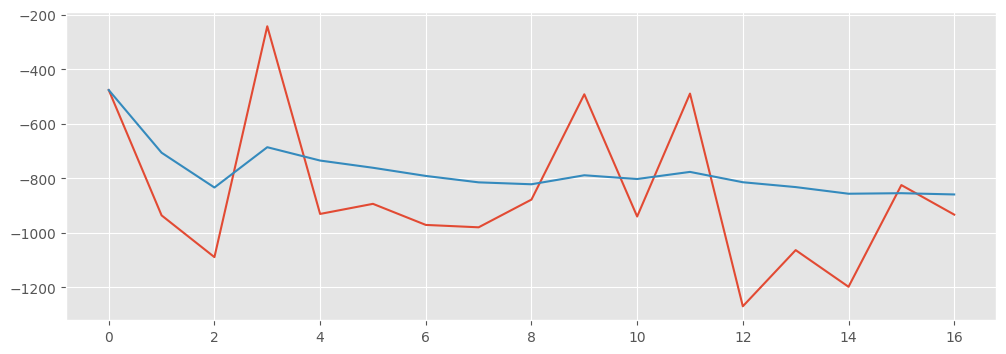

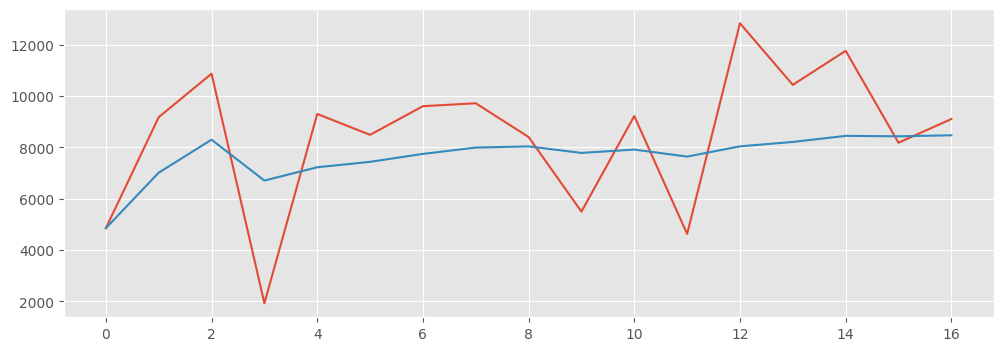

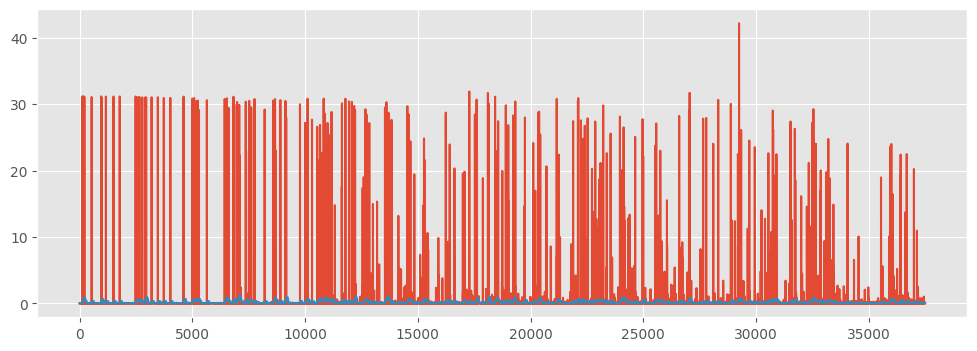

In [ ]:
### YOUR PLOTTING CODE HERE
plt.plot(range(len(cr_returns)), cr_returns)
plt.plot(range(len(cr_returns)), rolling_average(cr_returns, window_size=100))
plt.show()

plt.plot(range(len(cr_lengths)), cr_lengths)
plt.plot(range(len(cr_lengths)), rolling_average(cr_lengths, window_size=100))
plt.show()

plt.plot(range(len(cr_losses)), cr_losses)
plt.plot(range(len(cr_losses)), rolling_average(cr_losses, window_size=100))
plt.show()

### Visualization of the trained policies!

In [ ]:
buttons_all = []
for key_env, env in image_envs.items():
    try:
        checkpoint = torch.load(f'checkpoint_{env.spec.id}.pt')
    except FileNotFoundError:
        pass
    else:
        buttons = []
        for key, value in checkpoint.items():
            dqn = DQN.custom_load(value)
            
            def make_callback(env, dqn):
                def button_callback(button):
                    for b in buttons_all:
                        b.disabled = True

                    def policy(state):
                        tens = torch.tensor(state, dtype=torch.float32)
                        tens = tens[None, :]
                        return dqn(tens).argmax().item()
                    
                    render(env, policy)
                    
                    for b in buttons_all:
                        b.disabled = False
                        
                return button_callback
                
            button = widgets.Button(description=f'{key.replace("_", ".")}%')
            button.on_click(make_callback(env, dqn))
            buttons.append(button)
        
        print(f'{key_env}:')
        display(widgets.HBox(buttons))
        buttons_all.extend(buttons)

carRacing:


carRacingTest:
